# 100 Years of Baby Names in British Columbia

Interactive visualizations of baby names in British Columbia from 1915 to 2014. The data includes every first name that was chosen five or more times in a given year, and is published by the British Columbia Vital Statistics Agency. Raw data was downloaded from:

- https://catalogue.data.gov.bc.ca/dataset/most-popular-girl-names-for-the-past-100-years
- https://catalogue.data.gov.bc.ca/dataset/most-popular-boys-names-for-the-past-100-years

In [1]:
from ipywidgets import interact, fixed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import utils

sns.set_style('darkgrid')

In [3]:
data = utils.get_names_data(girls_file='data/bc-popular-girls-names.csv',
                            boys_file='data/bc-popular-boys-names.csv',
                            verbose=True)
print(data.shape)
data.head()

Loading data/bc-popular-girls-names.csv
Loading data/bc-popular-boys-names.csv
Processing raw data
Merging data
Performing calculations
(75365, 12)


,First Letter,Last Letter,Last 3 Letters,Year,Girls Count,Boys Count,Both Count,% of Girls,% of Boys,% of Both,Girls Fraction,Boys Fraction
Name,,,,,,,,,,,,
AADEN,A,N,DEN,2008,0.0,9.0,9.0,0.000000,0.052817,0.028516,0.0,1.0
AADEN,A,N,DEN,2009,0.0,13.0,13.0,0.000000,0.074516,0.040309,0.0,1.0
AALIYAH,A,H,YAH,2000,6.0,0.0,6.0,0.043328,0.000000,0.019995,1.0,0.0
AALIYAH,A,H,YAH,2001,13.0,0.0,13.0,0.094766,0.000000,0.043596,1.0,0.0
AALIYAH,A,H,YAH,2002,17.0,0.0,17.0,0.127122,0.000000,0.057916,1.0,0.0


In [4]:
cols = ['Girls Count', 'Boys Count', 'Both Count']
grand_totals = data[cols].groupby('Name').sum()
percent = 100 * grand_totals / grand_totals.sum()
percent = percent.rename(columns={f'{nm} Count' : f'% of {nm}' for nm in ['Girls', 'Boys', 'Both']})
grand_totals = grand_totals.join(percent)
for nm in ['Girls', 'Boys']:
    grand_totals[f'{nm} Share'] = grand_totals[f'{nm} Count'] / grand_totals['Both Count']
grand_totals['Gender Gap'] = grand_totals['Girls Share'] - grand_totals['Boys Share']
grand_totals.head()

,Girls Count,Boys Count,Both Count,% of Girls,% of Boys,% of Both,Girls Share,Boys Share,Gender Gap
Name,,,,,,,,,
AADEN,0.0,22.0,22.0,0.000000,0.001674,0.000891,0.0,1.0,-1.0
AALIYAH,308.0,0.0,308.0,0.026691,0.000000,0.012478,1.0,0.0,1.0
AANYA,12.0,0.0,12.0,0.001040,0.000000,0.000486,1.0,0.0,1.0
AARAV,0.0,79.0,79.0,0.000000,0.006010,0.003201,0.0,1.0,-1.0
AARON,0.0,6233.0,6233.0,0.000000,0.474212,0.252517,0.0,1.0,-1.0


In [5]:
#frac_min, frac_max = 0.25, 0.75
frac_min, frac_max = 0.4, 0.6
condition = (grand_totals['Girls Share'] >= frac_min) & (grand_totals['Girls Share'] <= frac_max)
unisex = grand_totals[condition]
unisex = unisex.sort_values('Both Count', ascending=False)
percent_cols = ['% of Girls', '% of Boys', '% of Both', 'Girls Share', 'Boys Share', 'Gender Gap']
unisex.head(20).style.format('{:.2%}', subset=percent_cols)

,Girls Count,Boys Count,Both Count,% of Girls,% of Boys,% of Both,Girls Share,Boys Share,Gender Gap
Name,,,,,,,,,
LESLIE,2339,2393,4732,20.27%,18.21%,19.17%,49.43%,50.57%,-1.14%
JAMIE,1859,1785,3644,16.11%,13.58%,14.76%,51.02%,48.98%,2.03%
ROBIN,1302,1806,3108,11.28%,13.74%,12.59%,41.89%,58.11%,-16.22%
KERRY,694,936,1630,6.01%,7.12%,6.60%,42.58%,57.42%,-14.85%
AMANDEEP,260,257,517,2.25%,1.96%,2.09%,50.29%,49.71%,0.58%
GURPREET,225,285,510,1.95%,2.17%,2.07%,44.12%,55.88%,-11.76%
MANDEEP,263,245,508,2.28%,1.86%,2.06%,51.77%,48.23%,3.54%
SKYLAR,247,204,451,2.14%,1.55%,1.83%,54.77%,45.23%,9.53%
AMRIT,240,203,443,2.08%,1.54%,1.79%,54.18%,45.82%,8.35%


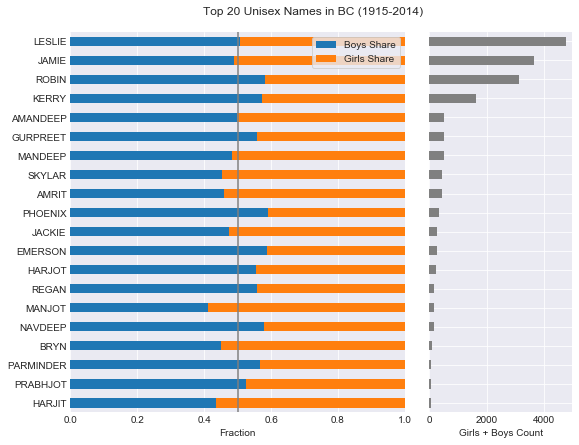

In [6]:
cols = ['Boys Share', 'Girls Share']
df = unisex.head(20)
fig, axes = plt.subplots(1, 2, figsize=(9, 7), sharey=True,
                         gridspec_kw={'wspace' : 0.1, 'width_ratios' : [0.7, 0.3]})

plt.sca(axes[0])
df[cols].plot.barh(ax=plt.gca(), stacked=True)
plt.legend(frameon=True)
plt.xlim(0, 1)
plt.ylabel('')
plt.xlabel('Fraction')
plt.axvline(0.5, color='0.5')

plt.sca(axes[1])
df['Both Count'].plot.barh(ax=plt.gca(), color='0.5')
plt.gca().invert_yaxis()
plt.xlabel('Girls + Boys Count')

plt.suptitle('Top 20 Unisex Names in BC (1915-2014)', y=0.93);

In [7]:
def percent_ticks(axis='y', ax=None):
    if ax is None:
        ax = plt.gca()
    if axis == 'y':
        ax.yaxis.set_major_formatter(PercentFormatter())
    else:
        ax.xaxis.set_major_formatter(PercentFormatter())

In [8]:
def extract_year(df, year):
    return df[df['Year'] == year]

In [9]:
def get_top_names(df, metric='Girls Count', ntop=10):
    return df[metric].sort_values(ascending=False).head(ntop)

In [10]:
def plot_top_names(df, years_label='', ntop=10, metrics=['% of Girls', '% of Boys'],
                   xlabel='% of Total', figsize=(12, 4.5)):      
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    plt.subplots_adjust(wspace=0.5)
    for metric, ax in zip(metrics, axes):
        plt.sca(ax)
        top_names = get_top_names(df, metric=metric, ntop=ntop)
        top_names.plot.barh(ax=ax, color='C0')
        plt.gca().invert_yaxis()
        title = f'Top {ntop} {metric} Names in BC ({years_label})'.replace(' Count','').replace('% of ', '')
        plt.title(title)
        plt.ylabel('')
        plt.xlabel(xlabel)
        if '%' in xlabel:
            percent_ticks(axis='x')

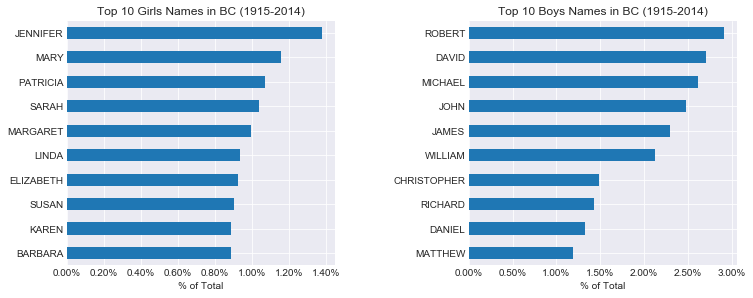

In [11]:
ntop = 10
yrmin, yrmax = data['Year'].min(), data['Year'].max()
years_label = f'{yrmin}-{yrmax}'
plot_top_names(grand_totals, years_label=years_label, ntop=ntop)
plt.savefig('scratch/grand_totals_top10.png')

In [12]:
@interact(data=fixed(data), year=(1915, 2014), ntop=fixed(ntop))
def yearly_top_names(data, year=2014, ntop=10):  
    df = extract_year(data, year)
    plot_top_names(df, years_label=f'{year}', ntop=ntop)

interactive(children=(IntSlider(value=2014, description='year', max=2014, min=1915), Output()), _dom_classes=(…

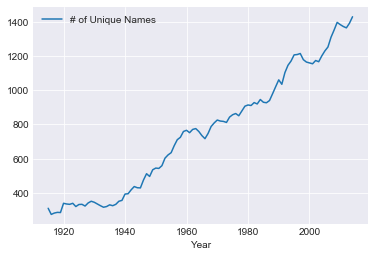

In [13]:
# Number of names per year
num_names = data[data['Both Count'] > 0].reset_index()[['Year', 'Name']]
num_names = num_names.groupby('Year').count().rename(columns={'Name' : '# of Unique Names'})
num_names.plot.line()

In [39]:
yrmin, ymax = 2000, 2014
condition = (data['Year'] >= yrmin) & (data['Year'] <= yrmax)
df = data[condition]
ntot = df['Both Count'].sum()
df = df.groupby('Last 3 Letters').sum().sort_values('Both Count', ascending=False).head(10)
df = df['Both Count'] / ntot
df.to_frame(name='Percent of Total').style.format('{:.2%}')

,Percent of Total
Last 3 Letters,
SON,3.09%
DEN,2.69%
HAN,1.97%
LEY,1.94%
NNA,1.57%
LLA,1.32%
GAN,1.31%
IAM,1.30%
TON,1.23%



SON
         Both Count
Name               
MADISON      2152.0
MASON        1892.0
JACKSON      1557.0
JASON         973.0
TYSON         969.0

DEN
         Both Count
Name               
JAYDEN       1934.0
AIDEN        1615.0
HAYDEN       1195.0
BRAYDEN      1089.0
JADEN         752.0

HAN
          Both Count
Name                
ETHAN         4368.0
NATHAN        2768.0
JONATHAN      1067.0
MEGHAN         228.0
ROHAN          179.0

LEY
         Both Count
Name               
RILEY        1817.0
HAILEY       1431.0
ASHLEY       1125.0
BAILEY        426.0
BRADLEY       389.0

NNA
         Both Count
Name               
ANNA         1208.0
JENNA         800.0
SIENNA        671.0
BRIANNA       633.0
ARIANNA       499.0

LLA
           Both Count
Name                 
ISABELLA       2094.0
ELLA           2008.0
STELLA          534.0
GABRIELLA       459.0
BELLA           303.0

GAN
        Both Count
Name              
LOGAN       2736.0
MEGAN       1169.0
MORGAN       932.0
TEAGAN   

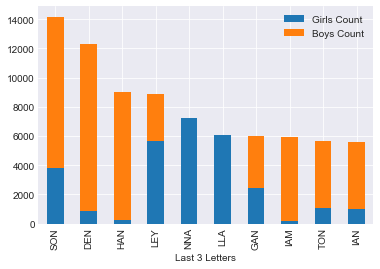

In [33]:
yrmin, ymax = 2000, 2014
condition = (data['Year'] >= yrmin) & (data['Year'] <= yrmax)
df = data[condition]
df2 = df.groupby('Last 3 Letters').sum().sort_values('Both Count', ascending=False).head(10)
df2[['Girls Count', 'Boys Count']].plot.bar(stacked=True)
vals = list(df2.index)
pivot = df.pivot_table(index=['Last 3 Letters', 'Name'], values='Both Count', aggfunc='sum')
for val in vals:
    print('\n' + val)
    print(pivot.loc[val].sort_values('Both Count', ascending=False).head(5))

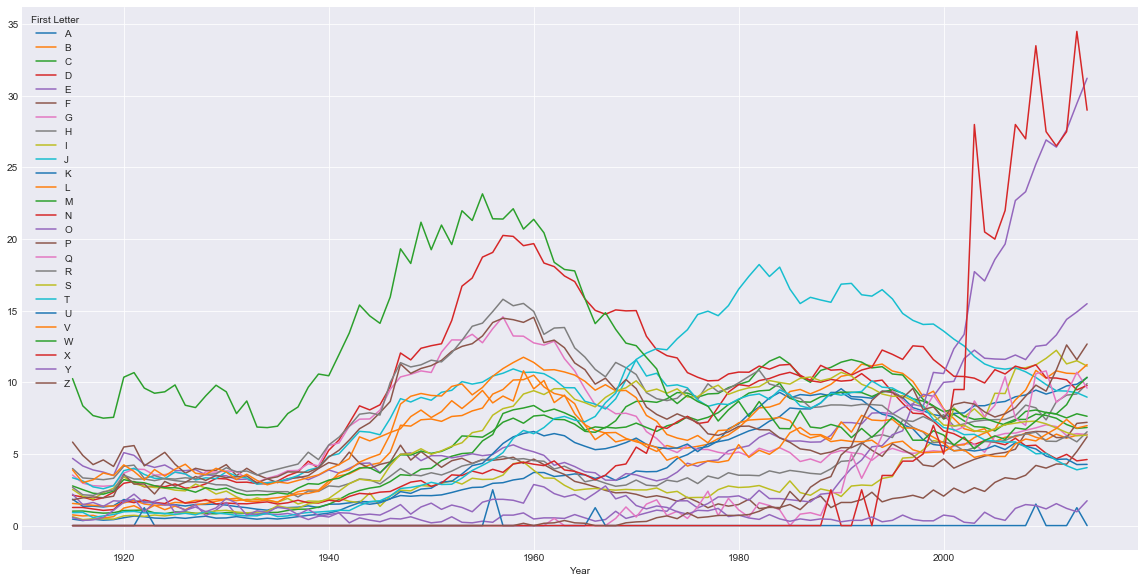

In [34]:
#data.groupby(['First Letter', 'Year']).sum()
pivot = data.pivot_table(index='Year', columns='First Letter', values='Both Count')
pivot.plot.line(figsize=(20, 10))

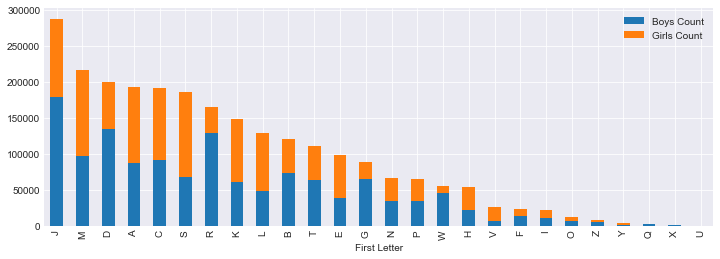

In [22]:
cols = ['First Letter', 'Girls Count', 'Boys Count', 'Both Count']
first_letter_totals = data[cols].groupby('First Letter').sum().sort_values('Both Count', ascending=False)
first_letter_totals[['Boys Count', 'Girls Count']].plot.bar(figsize=(12, 4), stacked=True)

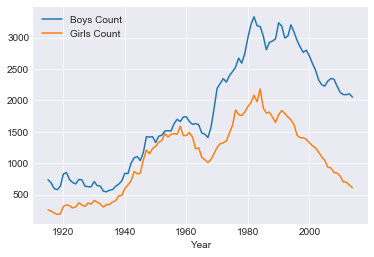

In [27]:
data[data['First Letter'] == 'J'].groupby('Year').sum()[['Boys Count', 'Girls Count']].plot.line()

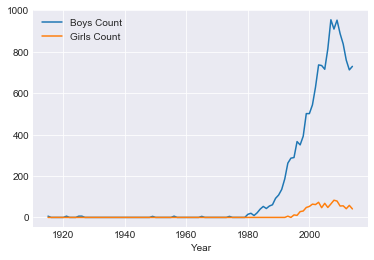

In [28]:
data[data['Last 3 Letters'] == 'DEN'].groupby('Year').sum()[['Boys Count', 'Girls Count']].plot.line()

### Stuff to do

Write a function to extract a subset of years from the dataframe and use a range slider widget to plot aggregates for the selected years of unisex names, top girl names, top boy names, etc.

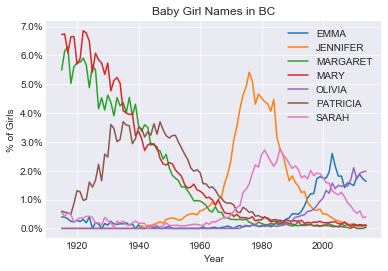

In [20]:
#names = ['EMMA', 'JENNIFER', 'MARY', 'OLIVIA', 'SARAH', 'SOPHIA']
names = ['JENNIFER', 'MARY', 'PATRICIA', 'MARGARET', 'OLIVIA', 'EMMA', 'SARAH']
metric =  '% of Girls'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.title('Baby Girl Names in BC')
#plt.grid(color='0.8')
#plt.savefig('scratch/some_girls_names.png')
plt.savefig('scratch/some_girls_names2.png')

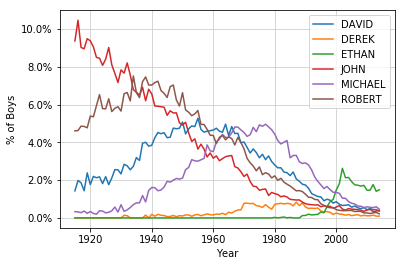

In [71]:
names = ['ROBERT', 'DAVID', 'MICHAEL', 'JOHN', 'ETHAN', 'DEREK']
metric =  '% of Boys'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/some_boys_names.png')

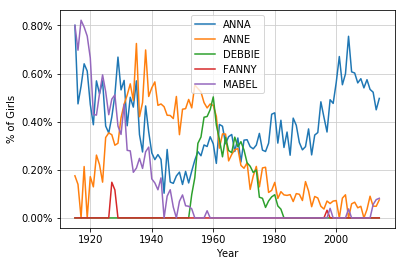

In [73]:
names = ['FANNY', 'ANNE', 'ANNA', 'DEBBIE', 'MABEL']
metric =  '% of Girls'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/fanny_and_others.png')

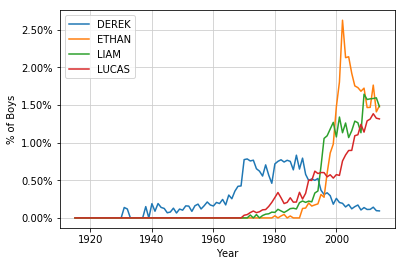

In [74]:
names = ['DEREK', 'LUCAS', 'ETHAN', 'LIAM']
metric =  '% of Boys'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/derek_and_others.png')

In [17]:
data[data.index.isin(['JENNIFER', 'JOHN', 'JORDAN', 'MORGAN']) & (data['Year'] == 1995)]

# Add some code to find and analyze unisex names

,Year,Girls Count,Boys Count,Both Count,Girls Yearly Total (All Names),Boys Yearly Total (All Names),Both Yearly Total (All Names),% of Girls,% of Boys,% of Both
Name,,,,,,,,,,
JENNIFER,1995,149.0,0.0,149.0,16580.0,19563.0,36143.0,0.898673,0.000000,0.412251
JOHN,1995,0.0,116.0,116.0,16580.0,19563.0,36143.0,0.000000,0.592956,0.320947
JORDAN,1995,31.0,321.0,352.0,16580.0,19563.0,36143.0,0.186972,1.640853,0.973909
MORGAN,1995,71.0,37.0,108.0,16580.0,19563.0,36143.0,0.428227,0.189133,0.298813


In [23]:
cols = ['Girls Count', 'Boys Count', 'Both Count']
sort_by = 'Boys Count'
data[cols].groupby('Name').sum().sort_values(sort_by, ascending=False).head(10)

,Girls Count,Boys Count,Both Count
Name,,,
ROBERT,0.0,38256.0,38256.0
DAVID,0.0,35629.0,35629.0
MICHAEL,0.0,34432.0,34432.0
JOHN,19.0,32598.0,32617.0
JAMES,0.0,30138.0,30138.0
WILLIAM,21.0,27885.0,27906.0
CHRISTOPHER,0.0,19472.0,19472.0
RICHARD,0.0,18827.0,18827.0
DANIEL,0.0,17457.0,17457.0


In [29]:
year = 1915
sort_by = 'Boys Count'
data[data['Year'] == year].sort_values(sort_by, ascending=False).head(10)

,Year,Girls Count,Boys Count,Both Count,Girls Yearly Total (All Names),Boys Yearly Total (All Names),Both Yearly Total (All Names),% of Girls,% of Boys,% of Both
Name,,,,,,,,,,
JOHN,1915,0.0,419.0,419.0,4000.0,4470.0,8470.0,0.0,9.373602,4.946871
WILLIAM,1915,0.0,344.0,344.0,4000.0,4470.0,8470.0,0.0,7.695749,4.061393
GEORGE,1915,0.0,229.0,229.0,4000.0,4470.0,8470.0,0.0,5.123043,2.703660
JAMES,1915,0.0,208.0,208.0,4000.0,4470.0,8470.0,0.0,4.653244,2.455726
ROBERT,1915,0.0,206.0,206.0,4000.0,4470.0,8470.0,0.0,4.608501,2.432113
THOMAS,1915,0.0,124.0,124.0,4000.0,4470.0,8470.0,0.0,2.774049,1.463991
CHARLES,1915,0.0,111.0,111.0,4000.0,4470.0,8470.0,0.0,2.483221,1.310508
ARTHUR,1915,0.0,109.0,109.0,4000.0,4470.0,8470.0,0.0,2.438479,1.286895
EDWARD,1915,0.0,94.0,94.0,4000.0,4470.0,8470.0,0.0,2.102908,1.109799


In [53]:
cols = ['Year', 'Girls Count', 'Boys Count', 'Both Count']
rankings = data[cols].groupby(['Name', 'Year']).rank(ascending=False)
rankings.head()

,Girls Count,Boys Count,Both Count
Name,,,
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0


In [57]:
year = 1981
metric = 'Girls Count'
series = data.loc[(data['Year'] == year) & (data[metric] > 0), metric]
series.rank(ascending=False).sort_values().head(10)

Name
JENNIFER    1.0
SARAH       2.0
AMANDA      3.0
MELISSA     4.0
LISA        5.0
MICHELLE    6.0
JESSICA     7.0
NICOLE      8.0
ERIN        9.5
CRYSTAL     9.5
Name: Girls Count, dtype: float64

In [56]:
year = 1915
metric = 'Boys Count'
series = data.loc[(data['Year'] == year) & (data[metric] > 0), metric]
series.rank(ascending=False).sort_values().head(10)

Name
JOHN        1.0
WILLIAM     2.0
GEORGE      3.0
JAMES       4.0
ROBERT      5.0
THOMAS      6.0
CHARLES     7.0
ARTHUR      8.0
EDWARD      9.0
DONALD     10.0
Name: Boys Count, dtype: float64